### DataFrame methods
https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.html

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, sum, count, unix_timestamp, hour, sec, regexp_replace
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set Up Spark Session

In [2]:
# Spark 세션 생성
spark = SparkSession.builder \
    .appName("W4M2 - NYC TLC") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/30 12:33:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load Data

In [3]:
file_path = "data/green_tripdata_2024-05.parquet"
df = spark.read.parquet(file_path)

df.show()

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2| 2024-05-01 00:07:08|  2024-05-01 00:15:03|                 N|         1|          65|          49|              1|         1.24|        9.3|  1.0|    0.

### Histogram

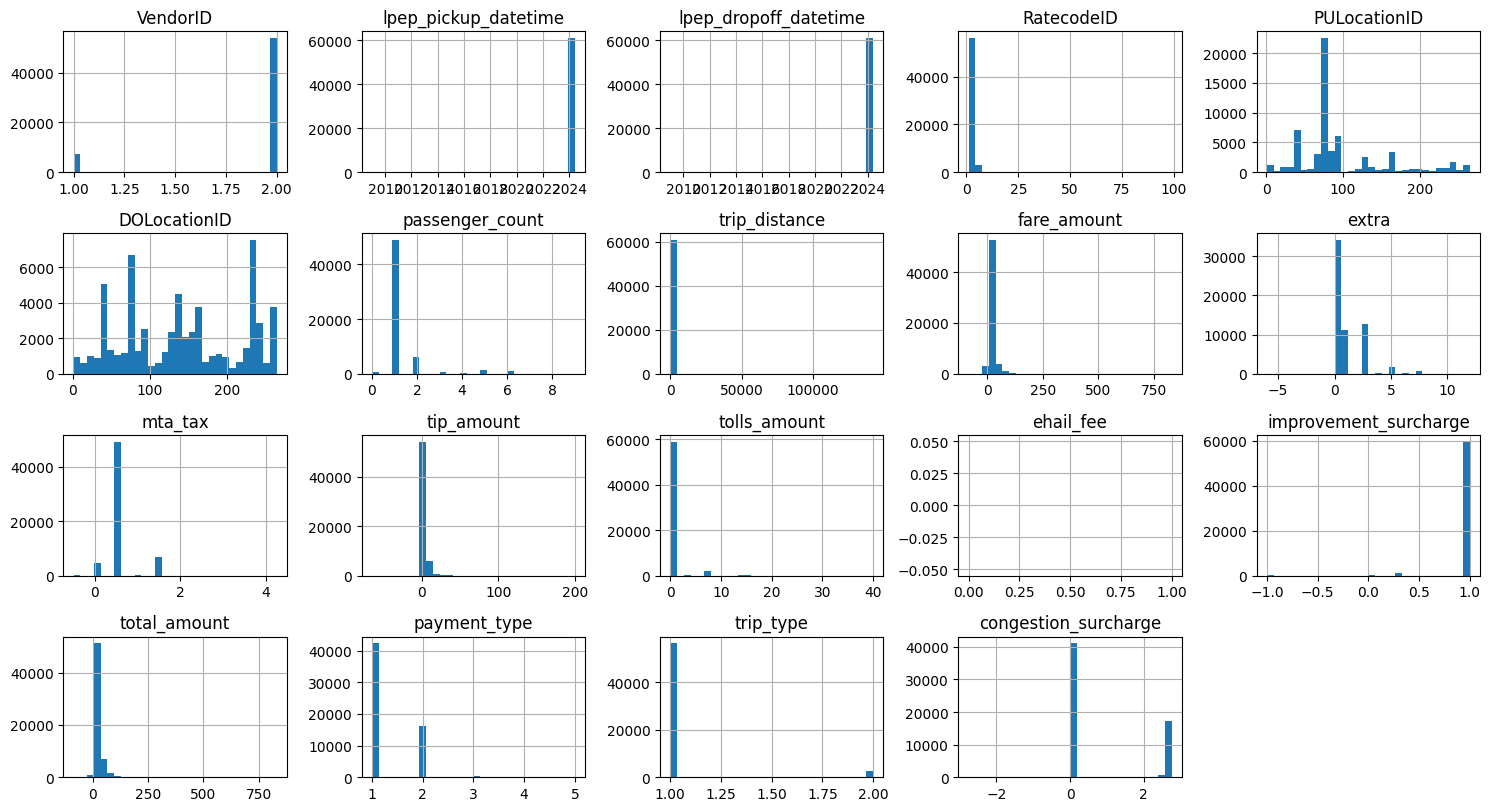

In [4]:
df_pd = df.toPandas()
df_pd.hist(bins=30, figsize=(15, 10), layout=(5, 5))

plt.tight_layout()
plt.show()

### Number of Rows

In [5]:
df.count()

61003

### Column names

In [6]:
df.columns

['VendorID',
 'lpep_pickup_datetime',
 'lpep_dropoff_datetime',
 'store_and_fwd_flag',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'ehail_fee',
 'improvement_surcharge',
 'total_amount',
 'payment_type',
 'trip_type',
 'congestion_surcharge']

# Clean and Transform Data

### 데이터 분석에 필요 없는 열 제거

In [7]:
# 공급업체 ID, 저장/전달 플래그, MTA 세금, 전자 호출 수수료
df = df.drop(col("VendorID"), col("store_and_fwd_flag"), col("mta_tax"), col("ehail_fee"))

### 누락된 값 제거

In [8]:
df = df.drop(col("ehail_fee"))
df = df.dropna()
df.count()

59097

### 타임스탬프 형식으로 변환

In [9]:
df = df.withColumn("lpep_pickup_datetime", to_timestamp(col("lpep_pickup_datetime"))) \
       .withColumn("lpep_dropoff_datetime", to_timestamp(col("lpep_dropoff_datetime")))

df.show()

+--------------------+---------------------+----------+------------+------------+---------------+-------------+-----------+-----+----------+------------+---------------------+------------+------------+---------+--------------------+
|lpep_pickup_datetime|lpep_dropoff_datetime|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------------------+---------------------+----------+------------+------------+---------------+-------------+-----------+-----+----------+------------+---------------------+------------+------------+---------+--------------------+
| 2024-05-01 00:07:08|  2024-05-01 00:15:03|         1|          65|          49|              1|         1.24|        9.3|  1.0|       2.0|         0.0|                  1.0|        13.8|           1|        1|                 0.0|
| 2024-05-01 00:30:48|  2024-05-01 00:35:49|         1|           7|

### 불가능한 값 필터링

#### Columns with values < 0

In [10]:
invalid_columns = []

for column in df.columns:
    # 열이 수치형 데이터인 경우에만 체크
    if df.schema[column].dataType in [pyspark.sql.types.IntegerType(), pyspark.sql.types.FloatType(), pyspark.sql.types.DoubleType(), pyspark.sql.types.LongType(), pyspark.sql.types.ShortType()]:
        # 0 이하의 값이 존재하는지 확인
        if df.filter(col(column) < 0).count() > 0:
            invalid_columns.append(column)

# 0 이하의 값이 존재하는 열 출력
if invalid_columns:
    for column in invalid_columns:
        print(column)
else:
    print("No invalid column")

fare_amount
extra
tip_amount
improvement_surcharge
total_amount
congestion_surcharge


In [11]:
# 일단 음수인 값이 존재하는 행을 필터링 했지만
# 0인 값도 필터링 해야할 수도 있음

for column in invalid_columns:
    df = df.filter(col(column) >= 0)
df.count()

58871

# Calculate Metrics

In [12]:
df = df.withColumn("trip_duration", unix_timestamp(col("lpep_dropoff_datetime")) - unix_timestamp(col("lpep_pickup_datetime")))

In [13]:
agg_df = df.agg(
    F.avg("trip_duration").alias("avg_trip_duration (seconds)"),
    F.avg("trip_distance").alias("avg_trip_distance (miles)"),
)

agg_df.show()

+---------------------------+-------------------------+
|avg_trip_duration (seconds)|avg_trip_distance (miles)|
+---------------------------+-------------------------+
|         1224.3908885529377|       2.7374055137503843|
+---------------------------+-------------------------+



In [14]:
df = df.withColumn("day", unix_timestamp(col("lpep_dropoff_datetime")) - unix_timestamp(col("lpep_pickup_datetime")))

# Analyze Peak Hours

In [15]:
hourly_trips = df.withColumn("hour", hour(col("lpep_pickup_datetime"))) \
                 .groupBy("hour") \
                 .count() \
                 .orderBy("hour")

hourly_trips.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1068|
|   1|  755|
|   2|  573|
|   3|  446|
|   4|  353|
|   5|  392|
|   6|  951|
|   7| 2204|
|   8| 2617|
|   9| 2902|
|  10| 2911|
|  11| 2769|
|  12| 3173|
|  13| 3019|
|  14| 3672|
|  15| 4119|
|  16| 4463|
|  17| 4594|
|  18| 4654|
|  19| 3742|
+----+-----+
only showing top 20 rows



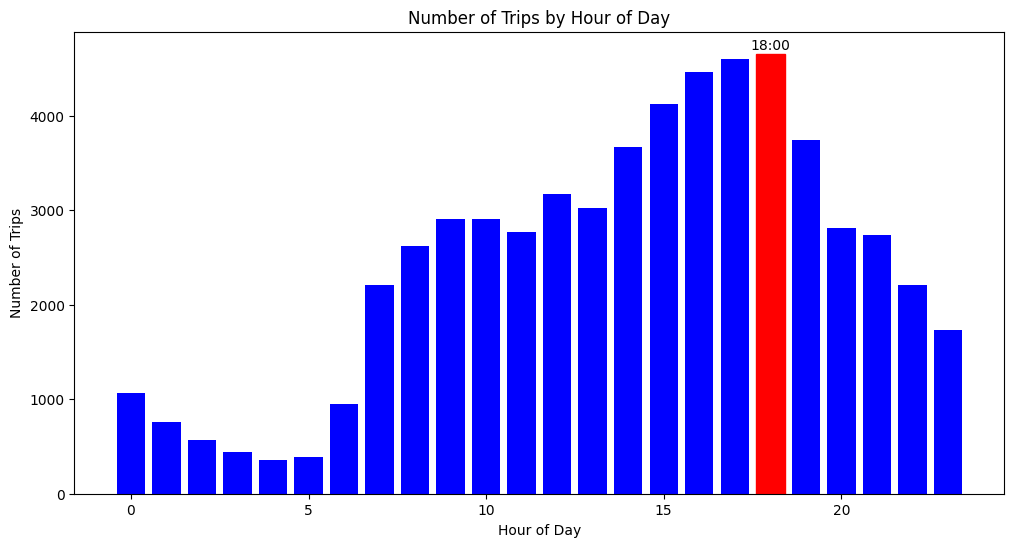

In [16]:
hourly_trips_pd = hourly_trips.toPandas()
max_trips = hourly_trips_pd['count'].max()
peak_hours = hourly_trips_pd[hourly_trips_pd['count'] == max_trips]['hour'].tolist()

plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_trips_pd['hour'], hourly_trips_pd['count'], color='blue')

for bar, h in zip(bars, hourly_trips_pd['hour']):
    if h in peak_hours:
        bar.set_color('red')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips by Hour of Day')

for h in peak_hours:
    plt.annotate(f'{h}:00',
                 xy=(h, max_trips),
                 xytext=(h, max_trips * 1.01),
                 ha='center',
                 fontsize=10)

plt.show()

# Analyze Peak Weather

In [17]:
weather_file_path = "may_2024_weather_data.csv"
weather_df = spark.read.option("header", "true").csv(weather_file_path)
weather_df.show()

+-------------------+-----------+--------+----------+--------+----------+
|           Datetime|Temperature|Humidity|Wind Speed|Pressure| Condition|
+-------------------+-----------+--------+----------+--------+----------+
|2024-05-01 00:00:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:01:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:02:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:03:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:04:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:05:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:06:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:07:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:08:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:09:00|      10.56|     86%|      5mph|   29.87|Light Rain|
|2024-05-01 00:10:00|      10.56|     

In [18]:
df_joined = df.join(weather_df, df.lpep_pickup_datetime == weather_df.Datetime, "inner")
df_joined.show()

+--------------------+---------------------+----------+------------+------------+---------------+-------------+-----------+-----+----------+------------+---------------------+------------+------------+---------+--------------------+-------------+----+-------------------+-----------+--------+----------+--------+-------------+
|lpep_pickup_datetime|lpep_dropoff_datetime|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|trip_duration| day|           Datetime|Temperature|Humidity|Wind Speed|Pressure|    Condition|
+--------------------+---------------------+----------+------------+------------+---------------+-------------+-----------+-----+----------+------------+---------------------+------------+------------+---------+--------------------+-------------+----+-------------------+-----------+--------+----------+--------+-------------+
| 2024-05-01 01:40:

### 전체 날씨 수 대비 택시 탑승 비율

비가 오는 때보다 구름끼고 바람 부는 때에 택시의 탑승 비율이 높다.\
비가 오는 때에는 아예 밖에 나오지 않는 것으로 생각된다.

In [19]:
# 날씨 별 발생 횟수
weather_count_by_condition = weather_df.groupBy("Condition").count().withColumnRenamed("count", "total_count")

# 날씨 별 택시 탑승 횟수
trip_count_by_condition = df_joined.groupBy("Condition").count().withColumnRenamed("count", "trip_count")

# 날씨 별 탑승 수의 비율
trip_count_by_condition = trip_count_by_condition.join(weather_count_by_condition, "Condition", "inner")
trip_count_by_condition = trip_count_by_condition.withColumn("normalized_count", (trip_count_by_condition["trip_count"] / trip_count_by_condition["total_count"]))

trip_count_by_condition_pd = trip_count_by_condition.select("Condition", "normalized_count").toPandas()

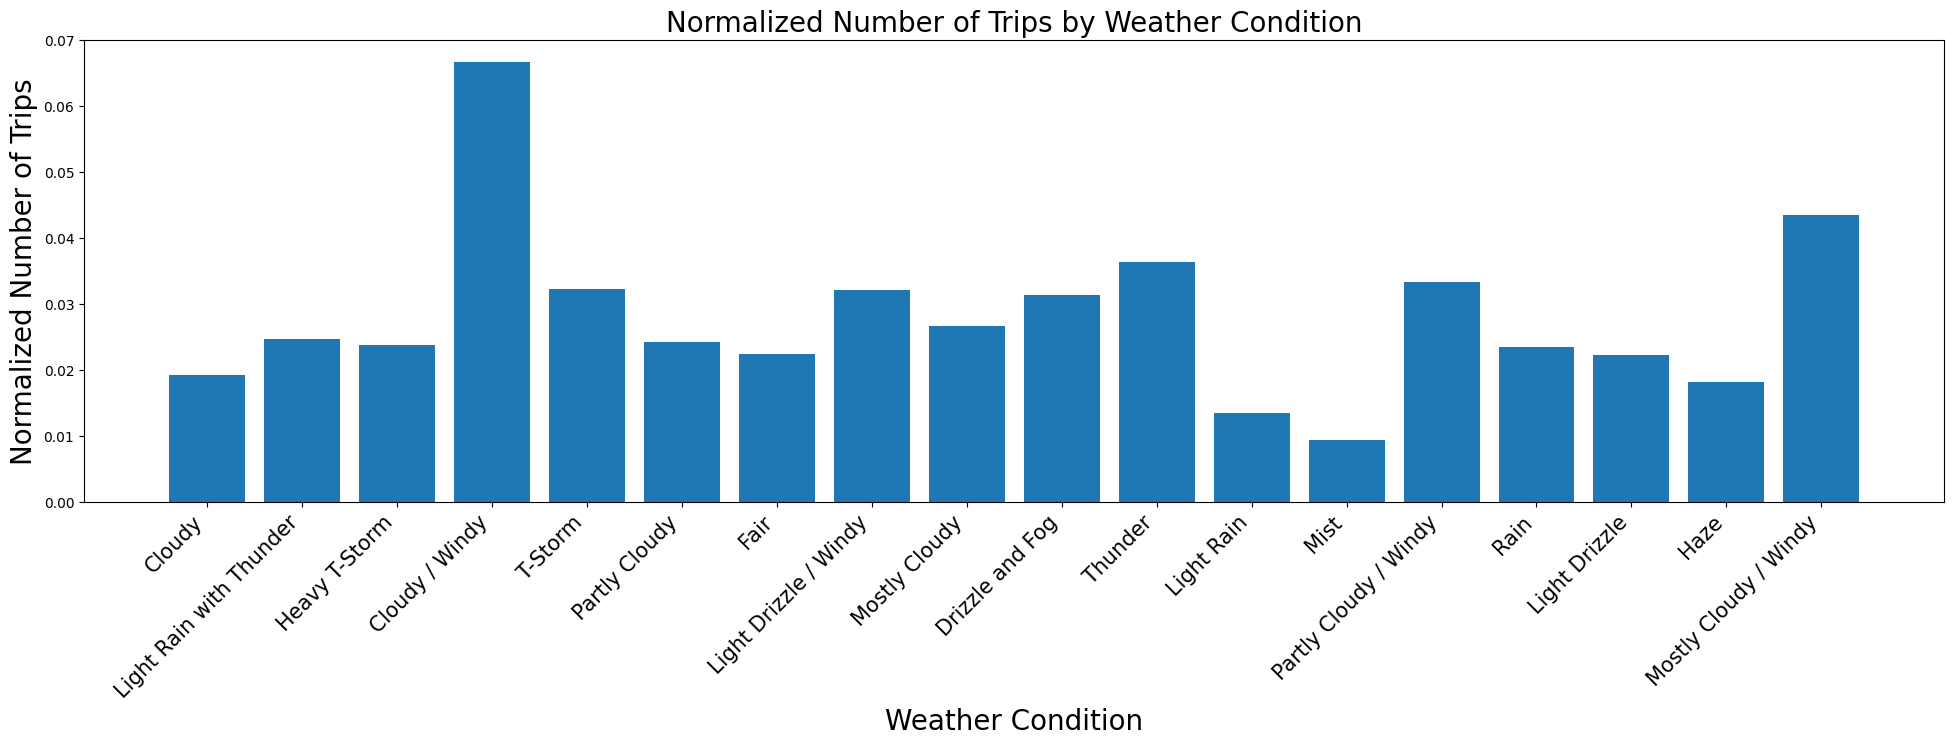

In [20]:
plt.figure(figsize=(24, 6))
plt.bar(trip_count_by_condition_pd['Condition'], trip_count_by_condition_pd['normalized_count'])
plt.xlabel('Weather Condition', fontsize=20)
plt.ylabel('Normalized Number of Trips', fontsize=20)
plt.xticks(rotation=45, fontsize=15, ha='right')
plt.title('Normalized Number of Trips by Weather Condition', fontsize=20)
plt.show()

### 온도 별 탑승 빈도

온도가 낮을 때 탑승 빈도가 커진다.\
하지만 온도는 시간에 따라 변하기 때문에 특정 시간에 많이 탑승하는 결과가 온도에 따른 탑승 빈도에 영향을 미쳤을 수 있다.

In [21]:
# 온도 별 전체 탑승 횟수
df_joined = df_joined.withColumn("intTemperature", F.round(df_joined["Temperature"], 0))
weather_count_by_temperature = df_joined.groupBy(col("intTemperature")).count().withColumnRenamed("count", "total_count")

# 전체 온도의 횟수
weather_df = weather_df.withColumn("intTemperature", F.round(weather_df["Temperature"], 0))
trip_count_by_temperature = weather_df.groupBy("intTemperature").count().withColumnRenamed("count", "trip_count")

# 온도 별 탑승 수의 비율
trip_count_by_temperature = trip_count_by_temperature.join(weather_count_by_temperature, "intTemperature", "inner")
trip_count_by_temperature = trip_count_by_temperature.withColumn("normalized_count", F.round((trip_count_by_temperature["trip_count"] / trip_count_by_temperature["total_count"]), 2))


trip_count_by_temperature_pd = trip_count_by_temperature.toPandas()

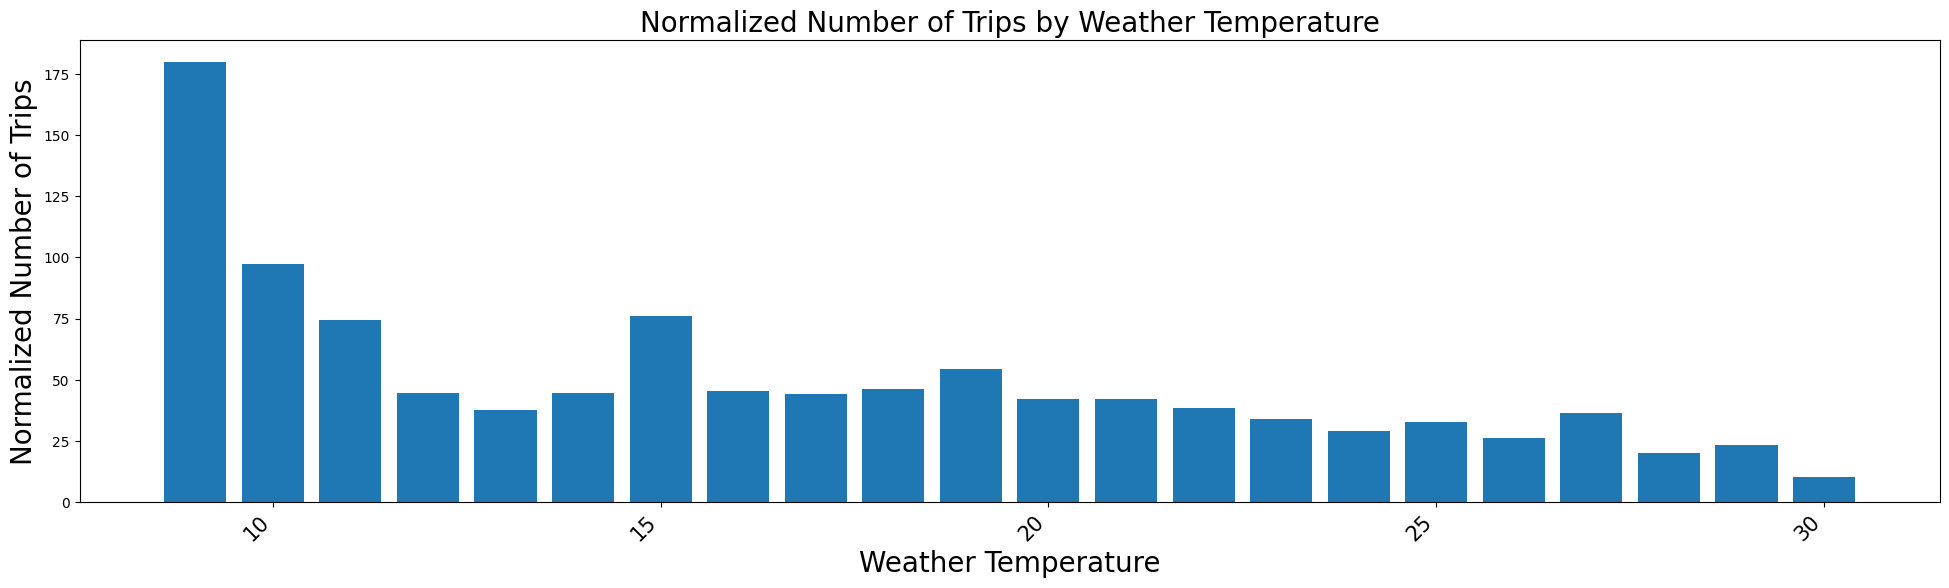

In [22]:
plt.figure(figsize=(24, 6))
plt.bar(trip_count_by_temperature_pd['intTemperature'], trip_count_by_temperature_pd['normalized_count'])
plt.xlabel('Weather Temperature', fontsize=20)
plt.ylabel('Normalized Number of Trips', fontsize=20)
plt.xticks(rotation=45, fontsize=15, ha='right')
plt.title('Normalized Number of Trips by Weather Temperature', fontsize=20)
plt.show()

### 시간-온도 별 탑승 빈도

온도가 낮을 때 택시가 탑승한다는 결론에는 비약이 있다.\
때문에 주요 시간대 별 온도에 따른 탑승 빈도를 재조사한다.\
시간대 별 온도 별 탑승 빈도를 조사하였다.\
명확한 상관관계를 확인할 수 없었다.

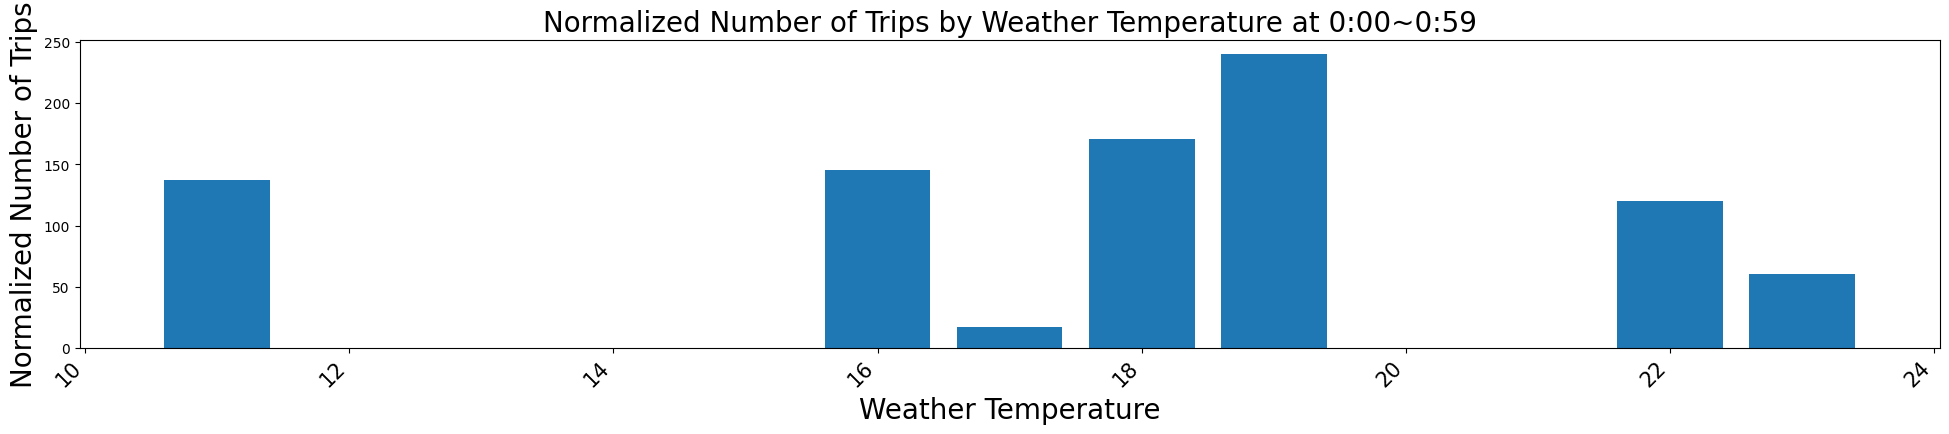

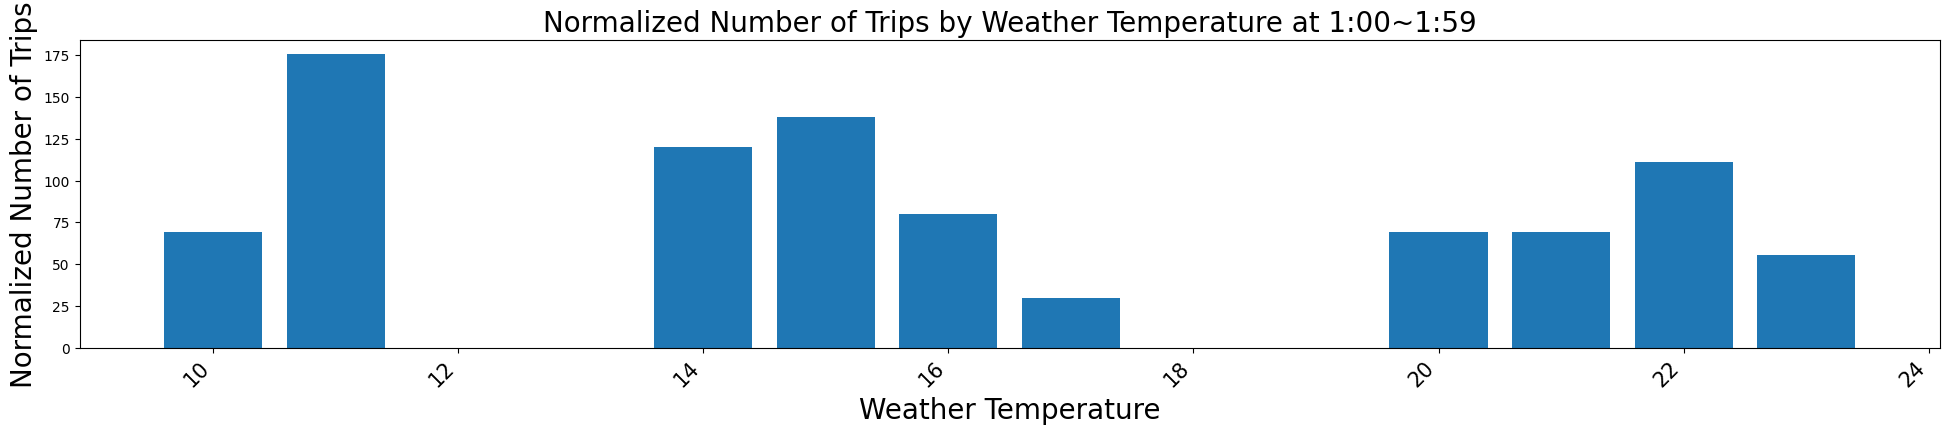

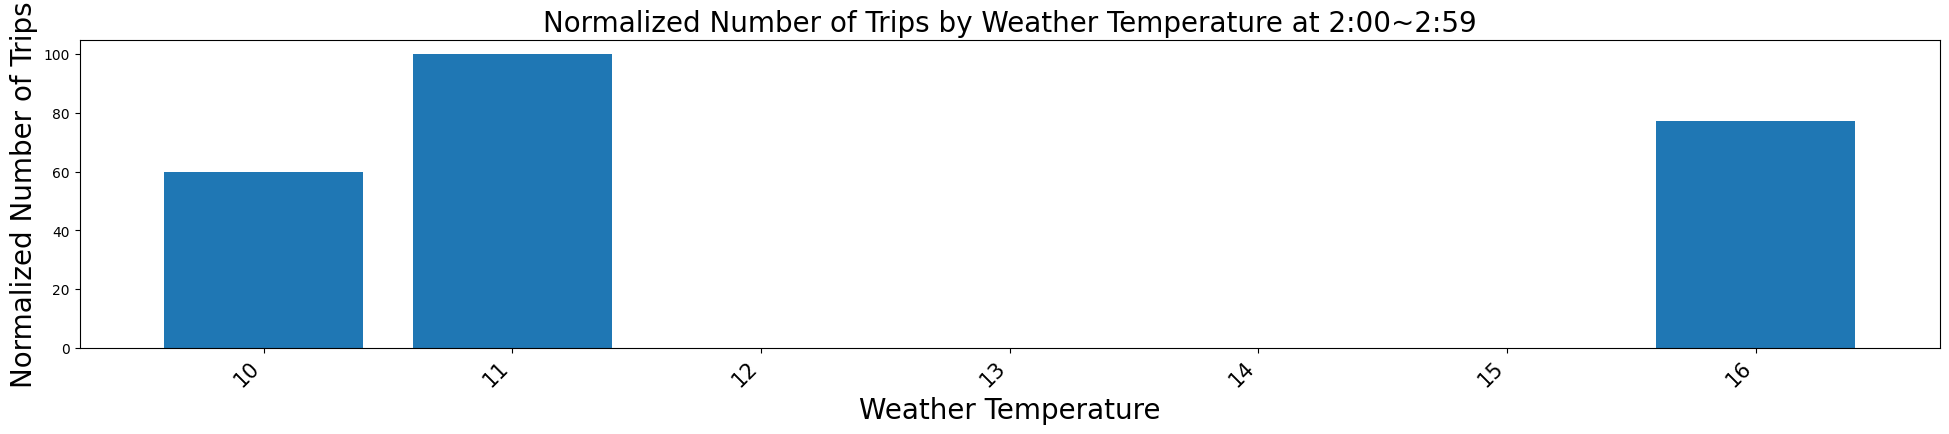

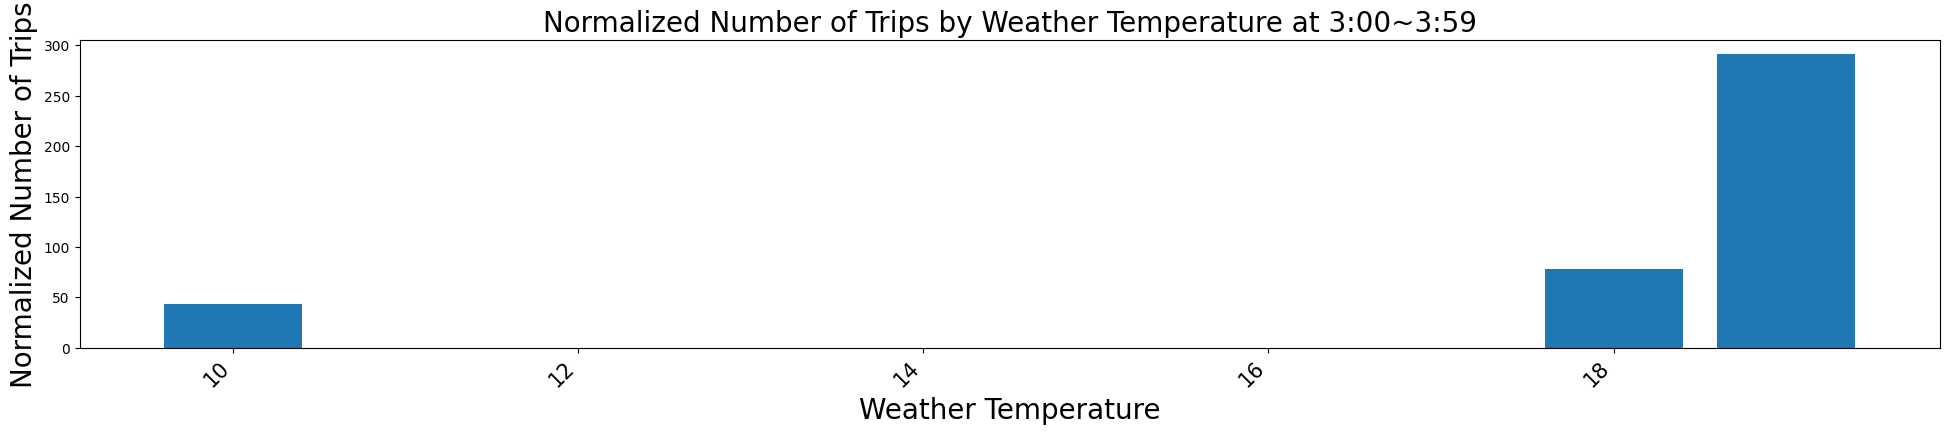

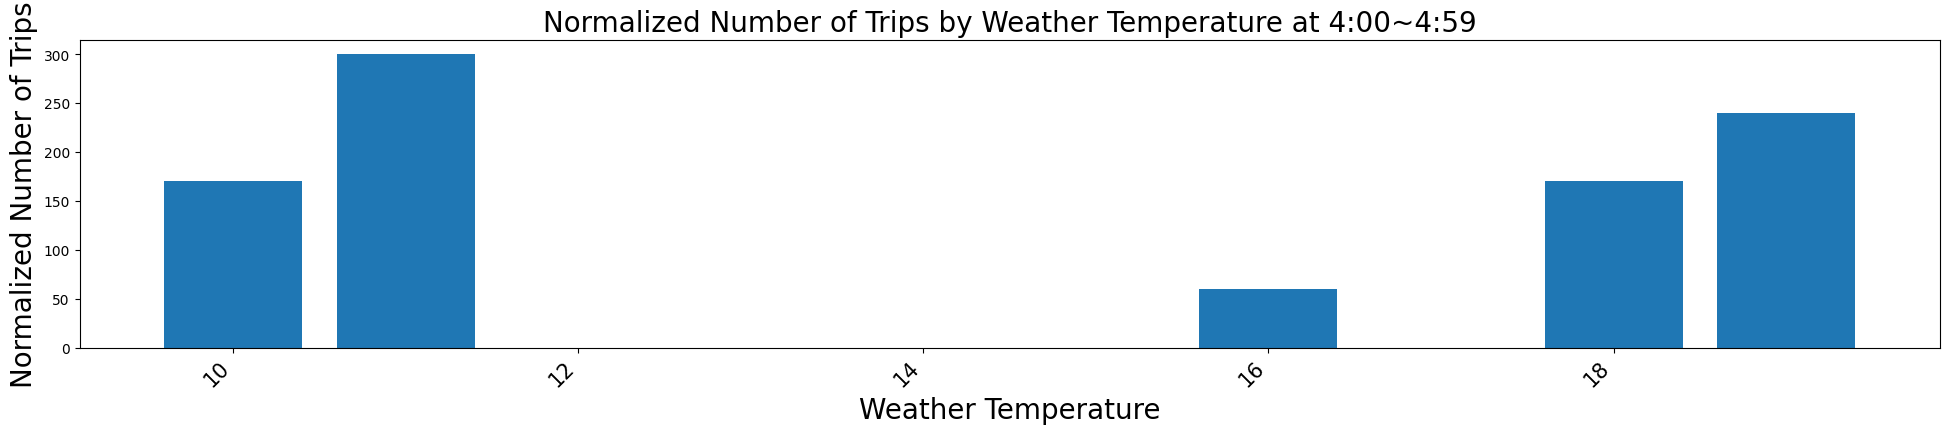

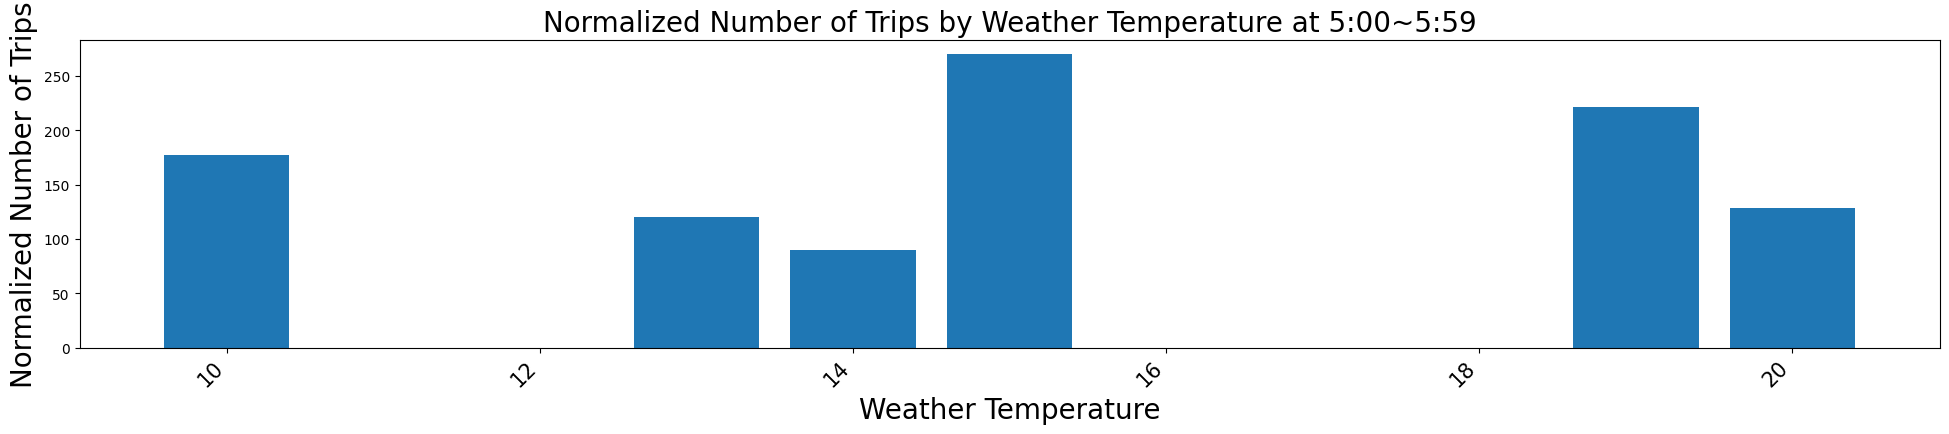

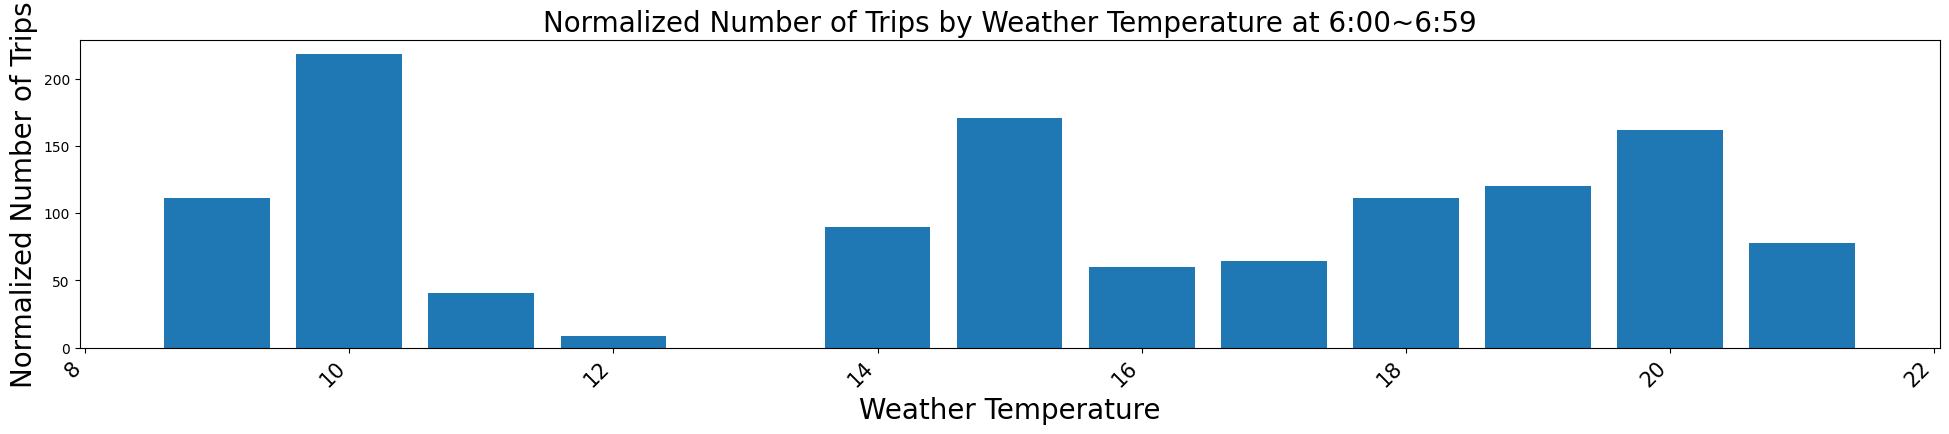

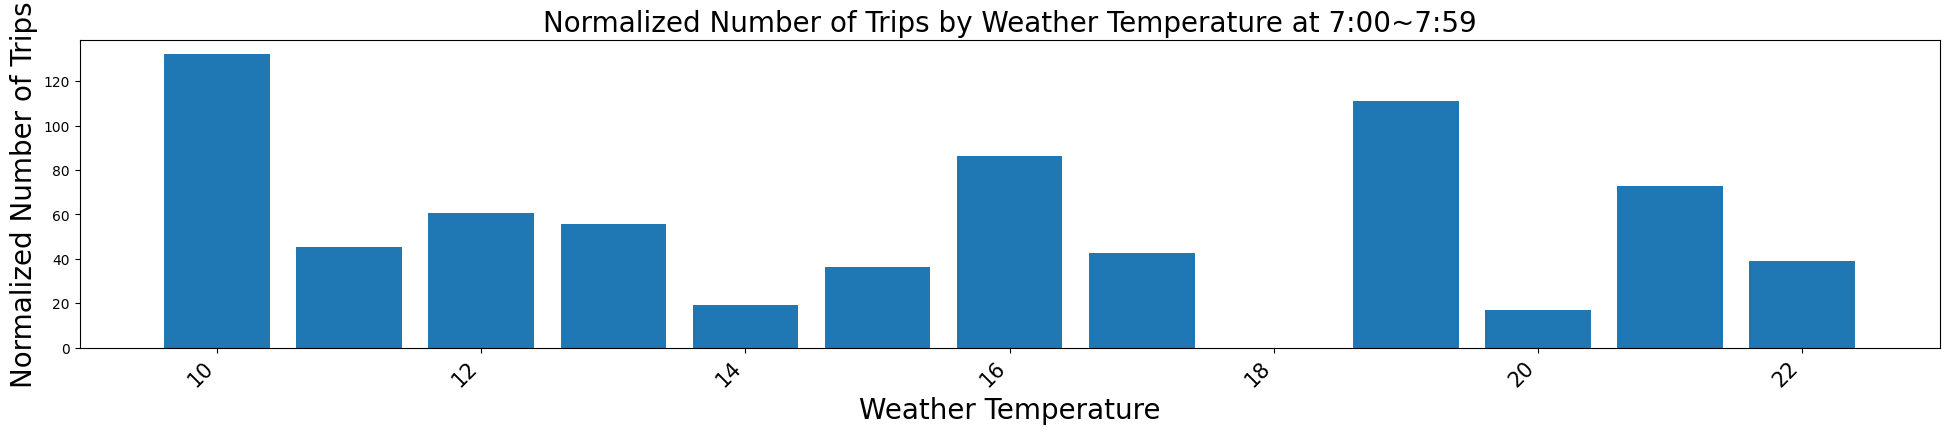

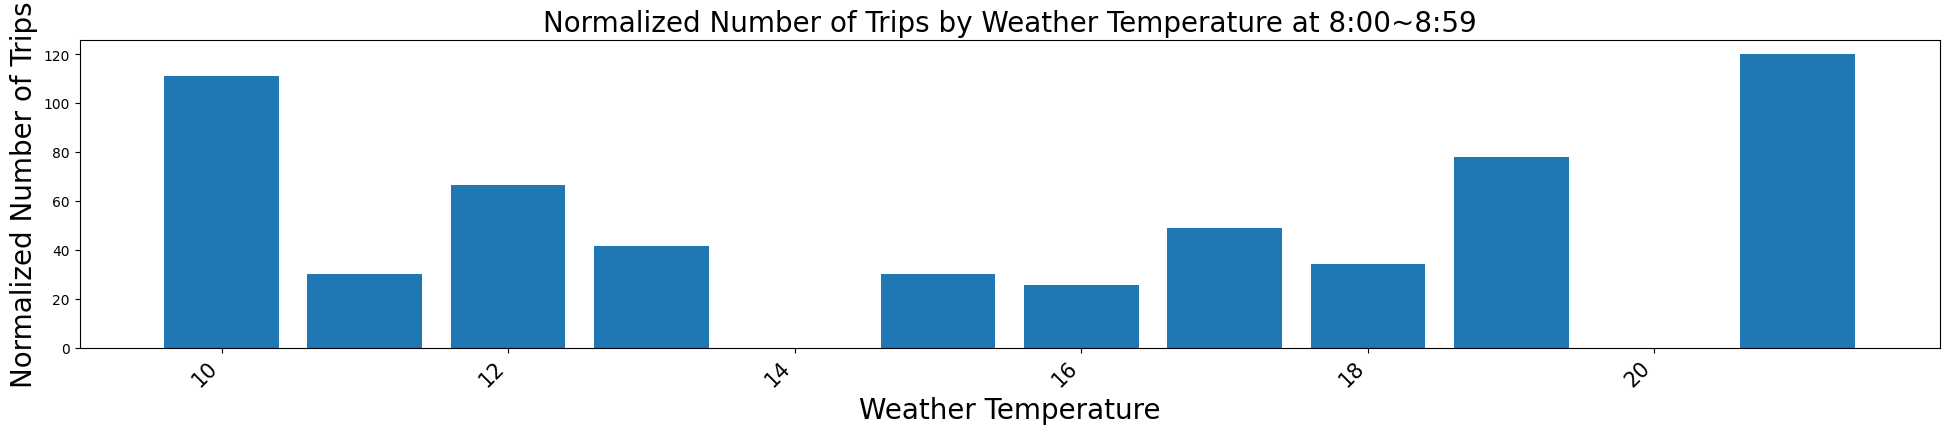

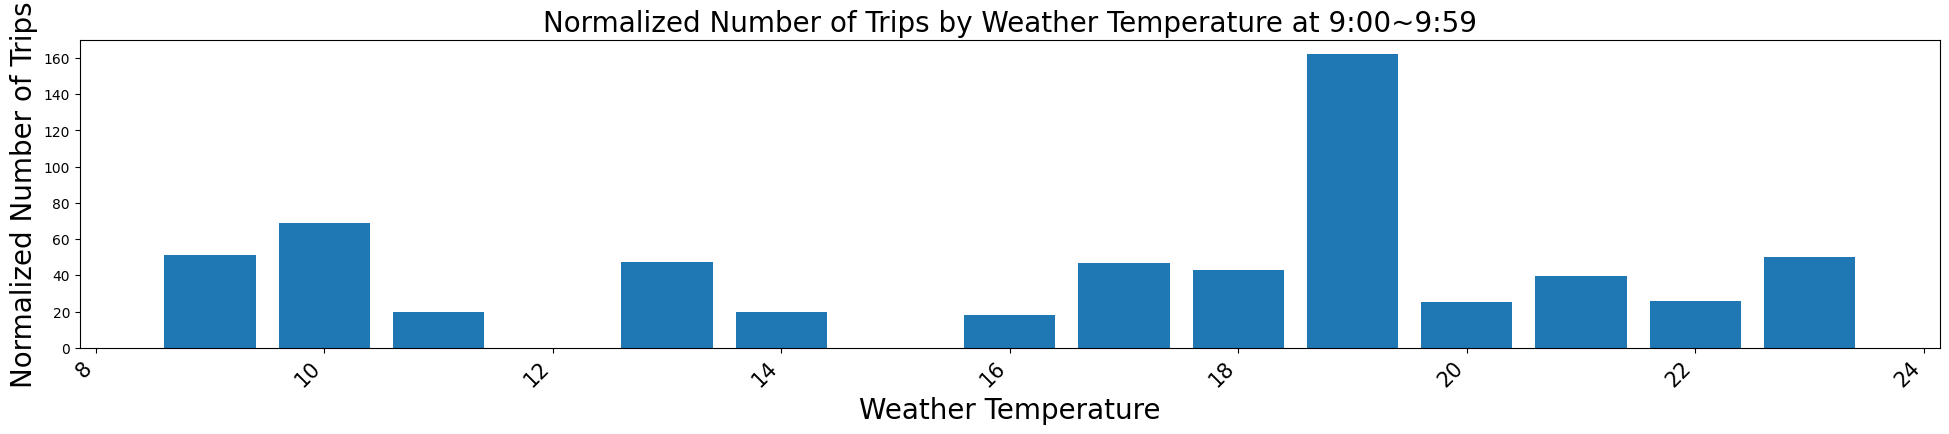

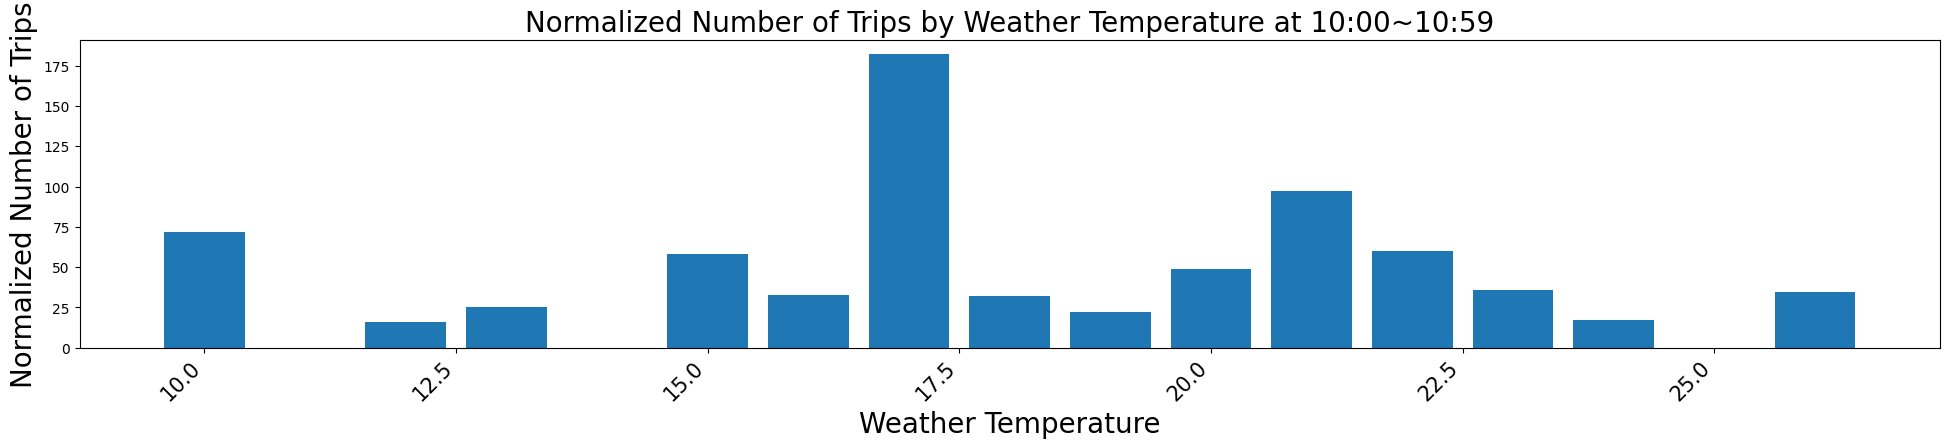

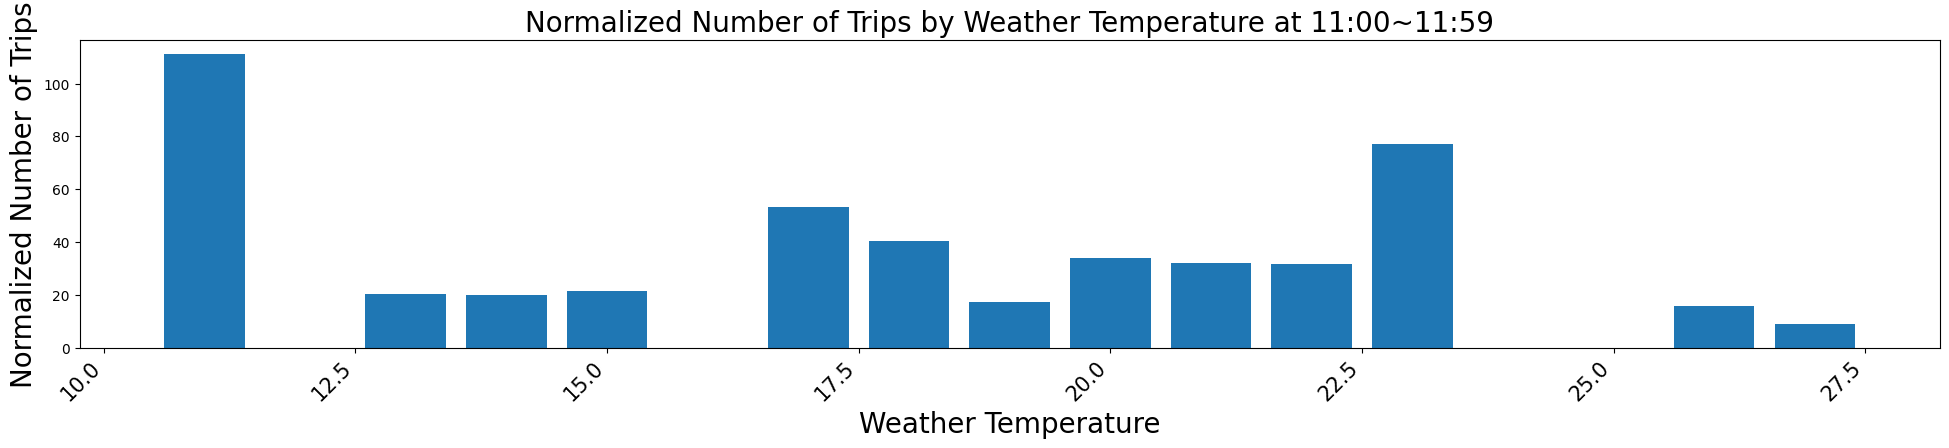

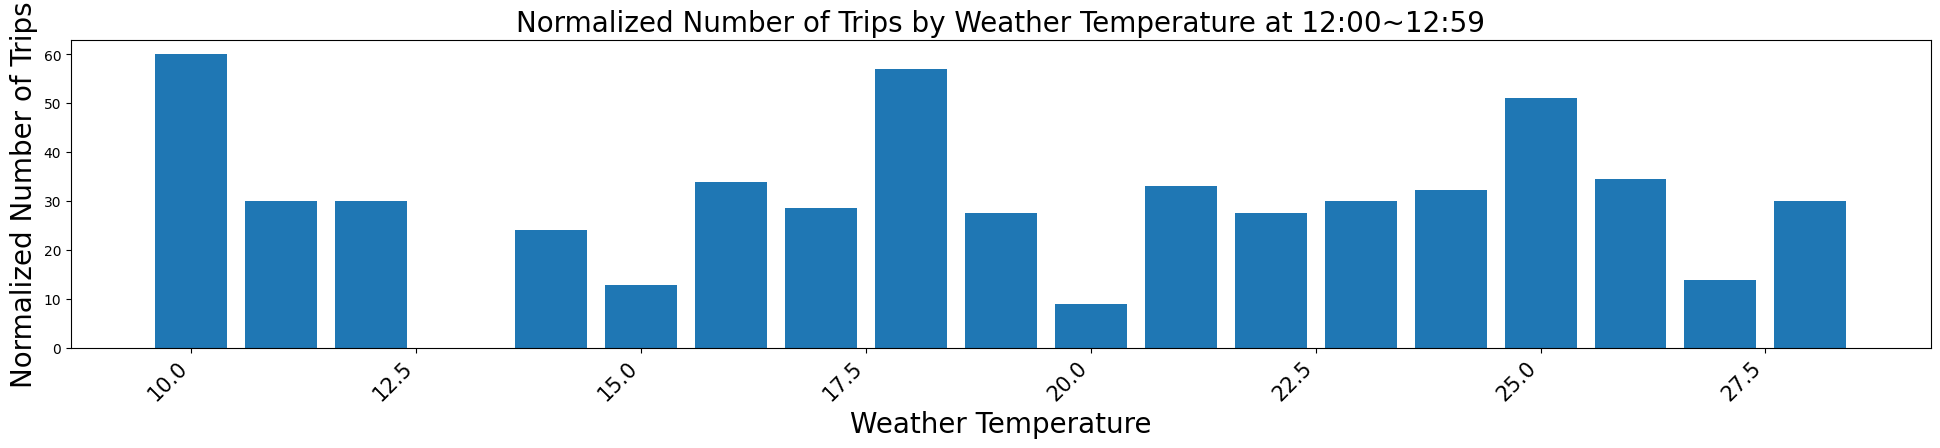

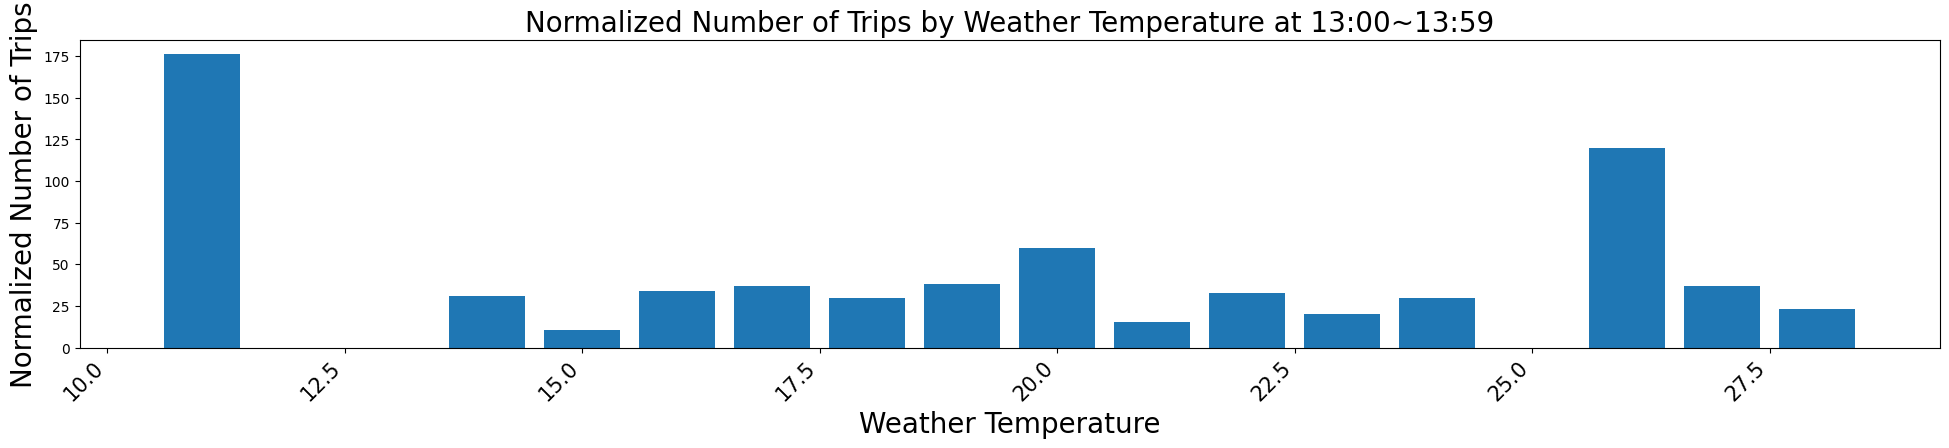

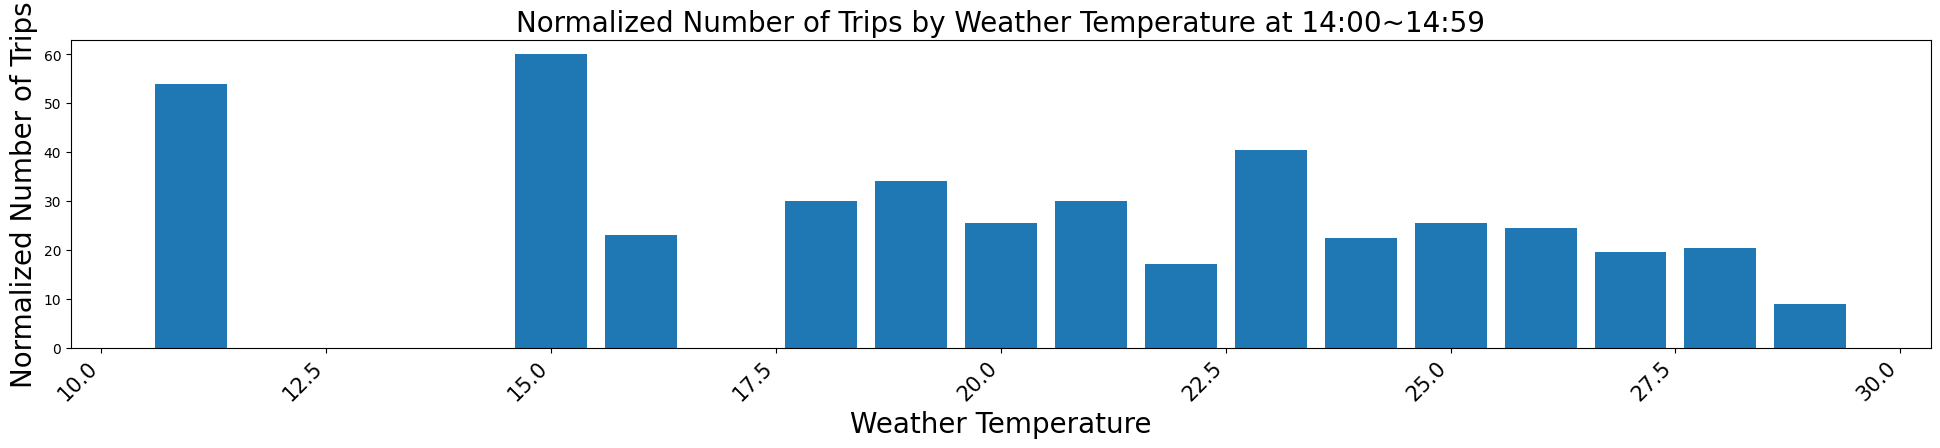

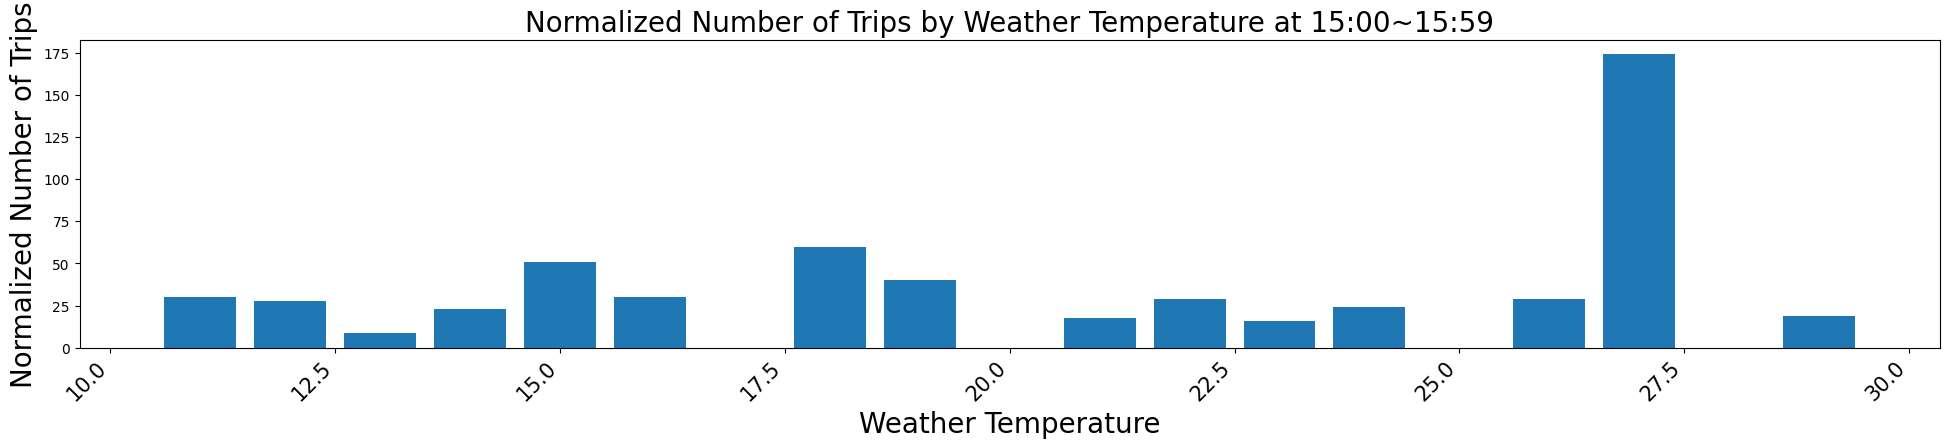

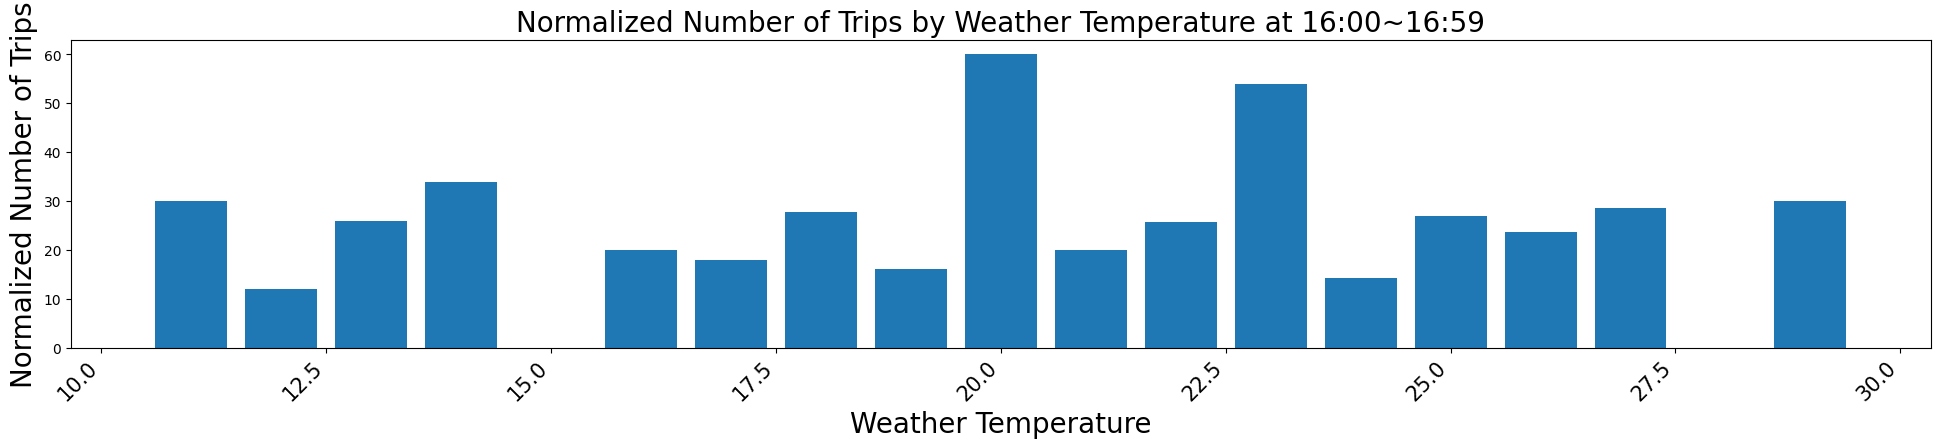

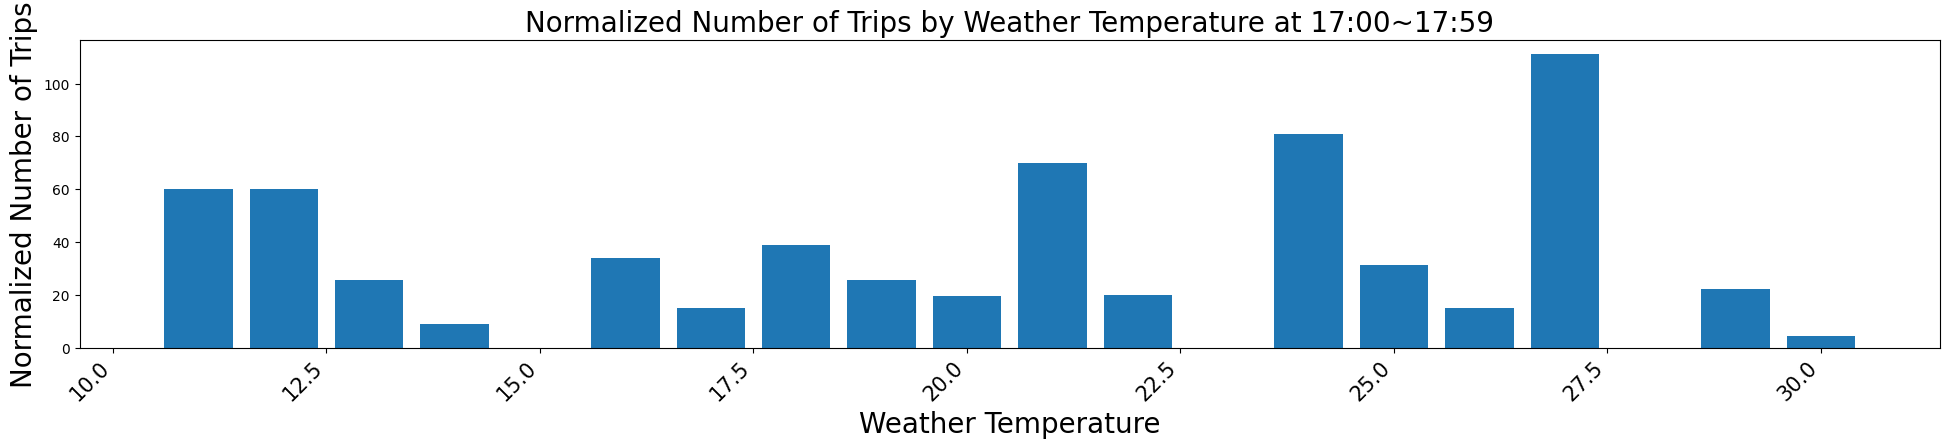

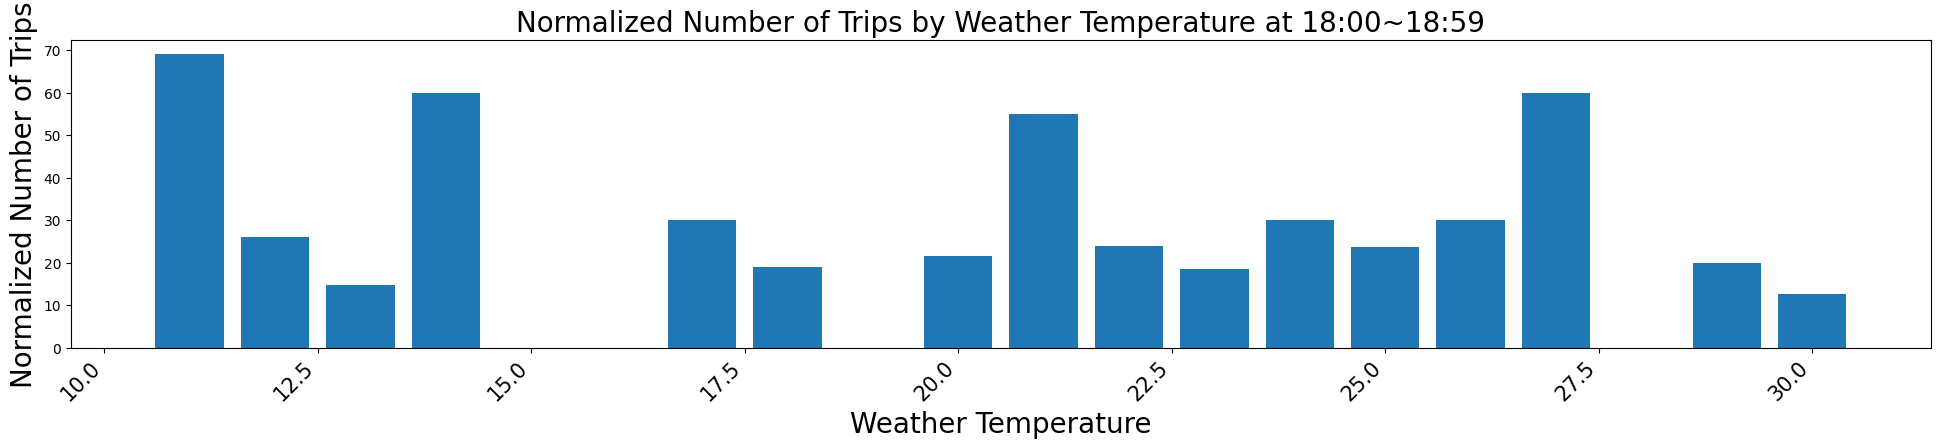

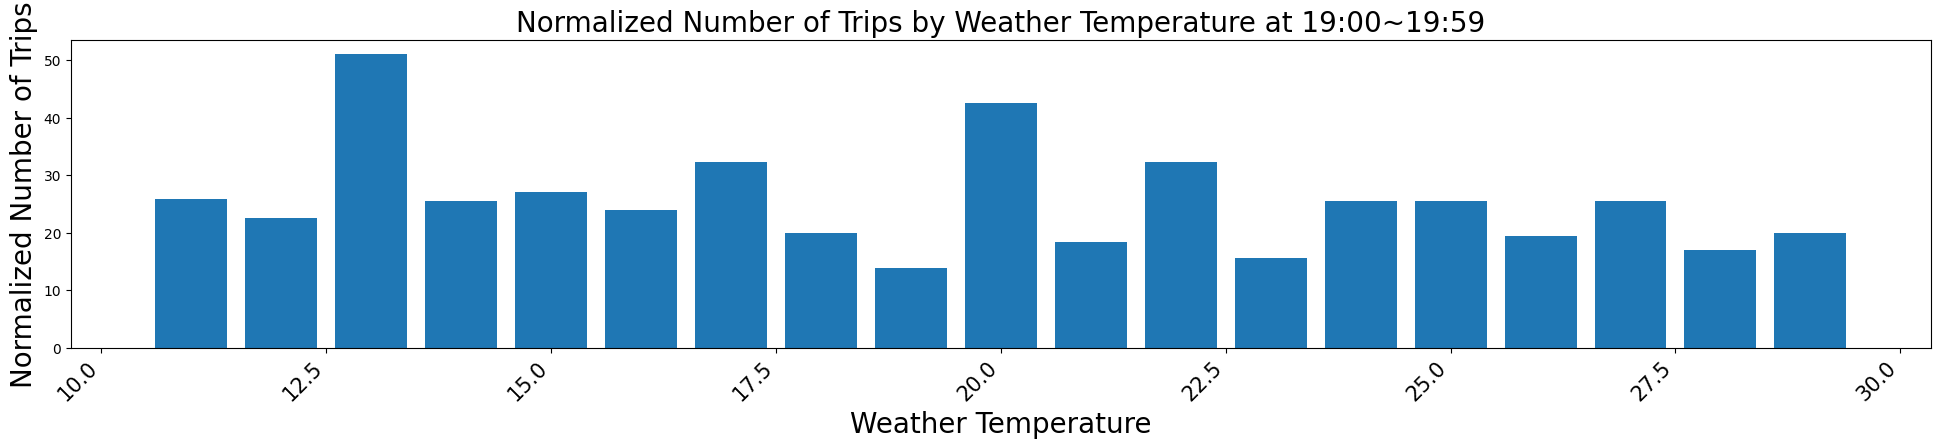

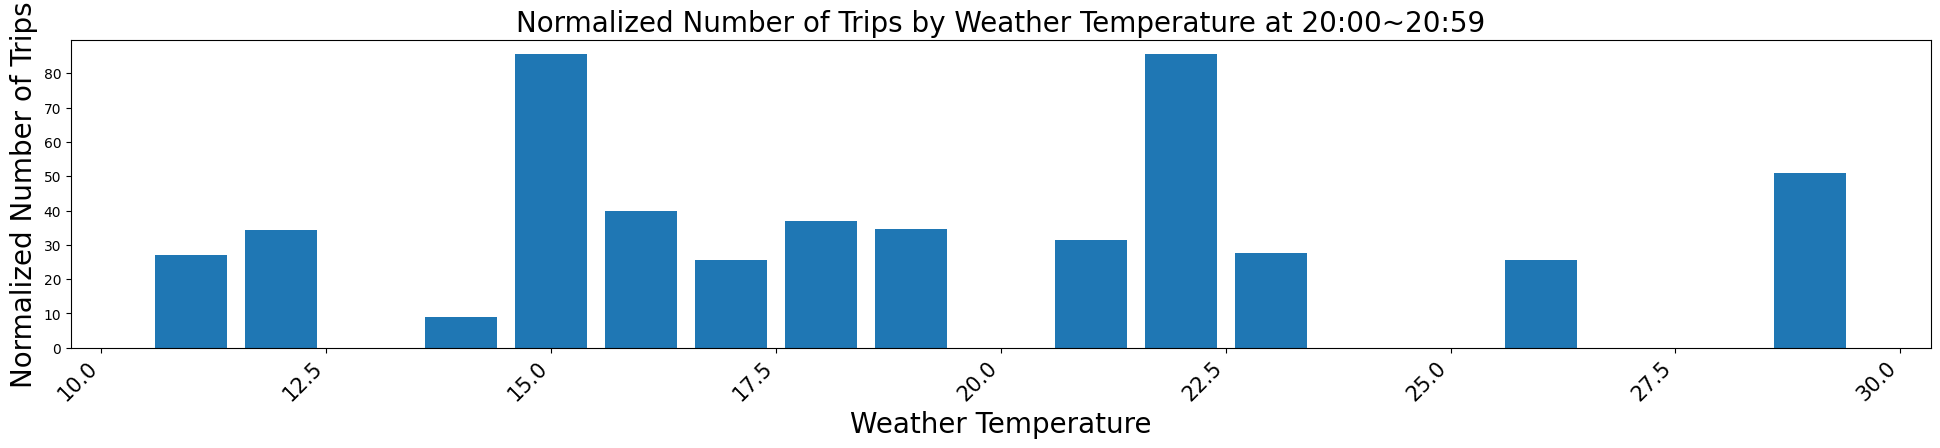

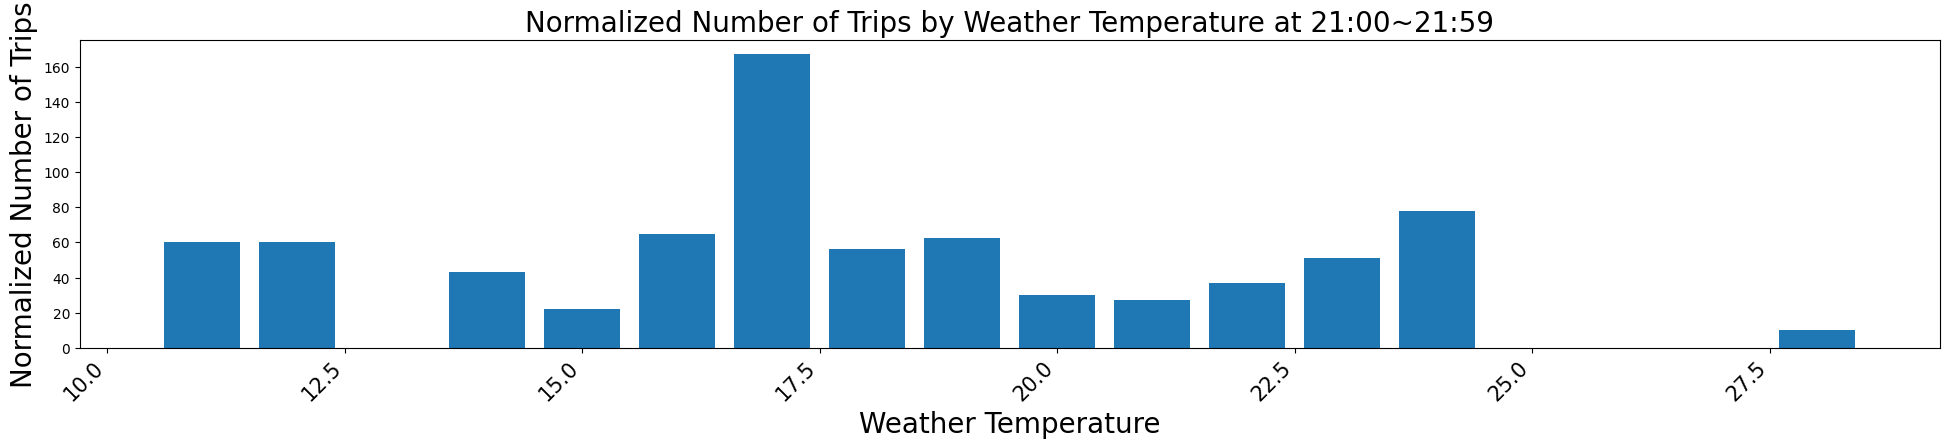

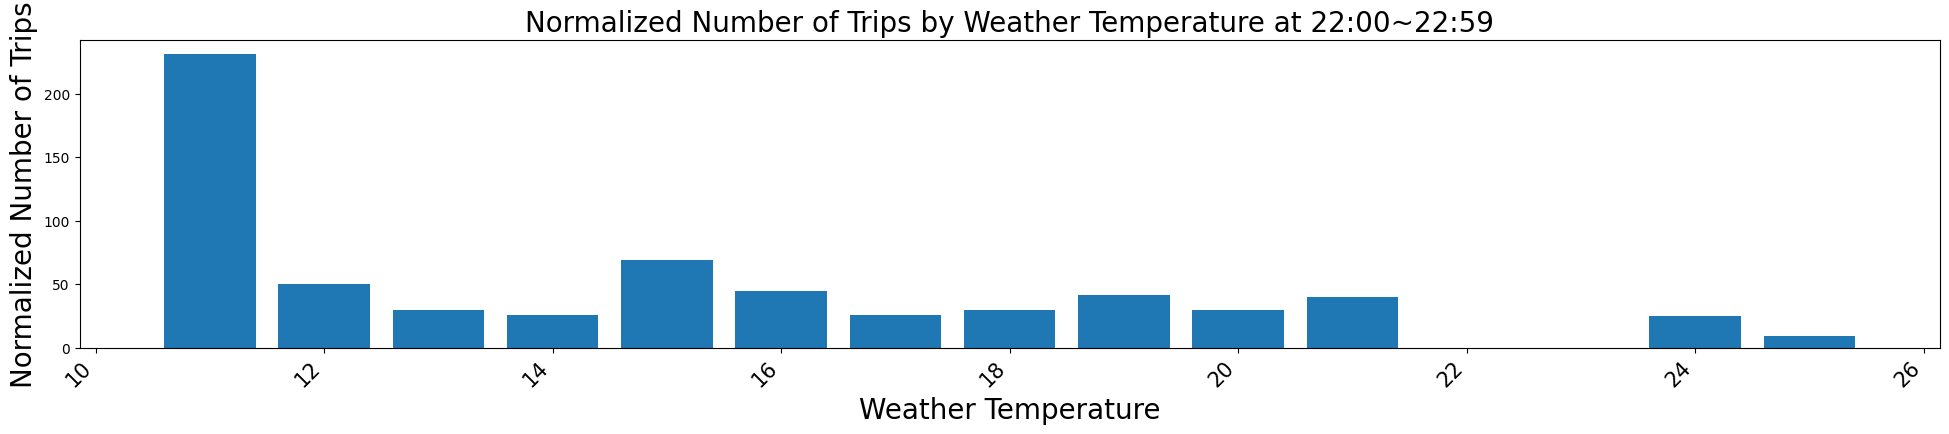

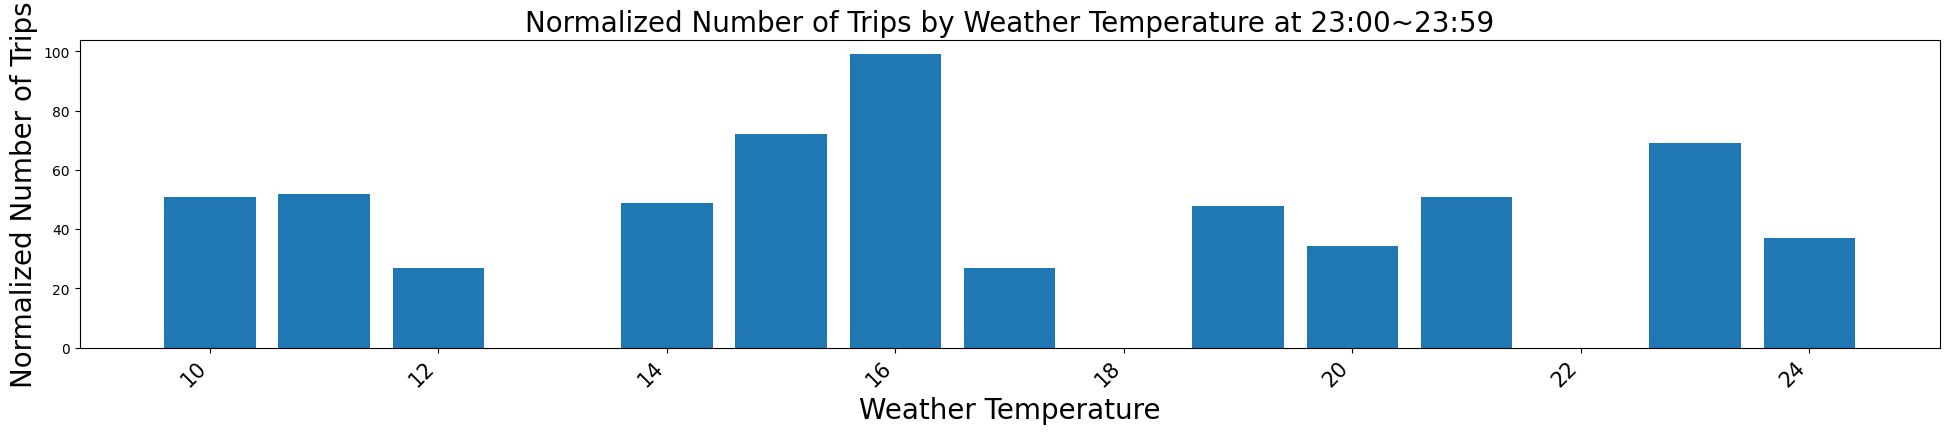

In [23]:
def calculate_trip_count_by_temperature(df_joined, weather_df, target_hour):
    df_joined_filtered = df_joined.filter((hour(col("Datetime")) == target_hour))
    weather_df_filtered = weather_df.filter((hour(col("Datetime")) == target_hour))
    
    df_joined_filtered = df_joined_filtered.withColumn("intTemperature", F.round(df_joined_filtered["Temperature"], 0))
    weather_count_by_temperature = df_joined_filtered.groupBy(col("intTemperature")).count().withColumnRenamed("count", "total_count")

    weather_df_filtered = weather_df_filtered.withColumn("intTemperature", F.round(weather_df_filtered["Temperature"], 0))
    trip_count_by_temperature = weather_df_filtered.groupBy("intTemperature").count().withColumnRenamed("count", "trip_count")

    trip_count_by_temperature = trip_count_by_temperature.join(weather_count_by_temperature, "intTemperature", "inner")
    trip_count_by_temperature = trip_count_by_temperature.withColumn("normalized_count", F.round((trip_count_by_temperature["trip_count"] / trip_count_by_temperature["total_count"]), 2))

    trip_count_by_temperature_pd = trip_count_by_temperature.toPandas()
    return trip_count_by_temperature_pd

for h in range(24):
    result = calculate_trip_count_by_temperature(df_joined, weather_df, h)
    plt.figure(figsize=(24, 4))
    plt.bar(result['intTemperature'], result['normalized_count'])
    plt.xlabel('Weather Temperature', fontsize=20)
    plt.ylabel('Normalized Number of Trips', fontsize=20)
    plt.xticks(rotation=45, fontsize=15, ha='right')
    plt.title(f'Normalized Number of Trips by Weather Temperature at {h}:00~{h}:59', fontsize=20)
    plt.show()

### 습도별 탑승 빈도

습도가 높아질 수록 택시의 탑승 빈도가 커지는 경향을 보인다.\
하지만 습도는 날씨와 시간의 영향을 크게 받으므로 이들과의 독립성 여부를 판단할 필요가 있다.

In [24]:
# 습도 별 전체 탑승 횟수
df_joined = df_joined.withColumn("intHumidity", regexp_replace(col("Humidity"), "%", "").cast("int"))
weather_count_by_Humidity = df_joined.groupBy(col("intHumidity")).count().withColumnRenamed("count", "total_count")

# 전체 온도의 횟수
weather_df = weather_df.withColumn("intHumidity", regexp_replace(col("Humidity"), "%", "").cast("int"))
trip_count_by_Humidity = weather_df.groupBy("intHumidity").count().withColumnRenamed("count", "trip_count")

# 온도 별 탑승 수의 비율
trip_count_by_Humidity = trip_count_by_Humidity.join(weather_count_by_Humidity, "intHumidity", "inner")
trip_count_by_Humidity = trip_count_by_Humidity.withColumn("normalized_count", F.round((trip_count_by_Humidity["trip_count"] / trip_count_by_Humidity["total_count"]), 2))


trip_count_by_Humidity_pd = trip_count_by_Humidity.toPandas()

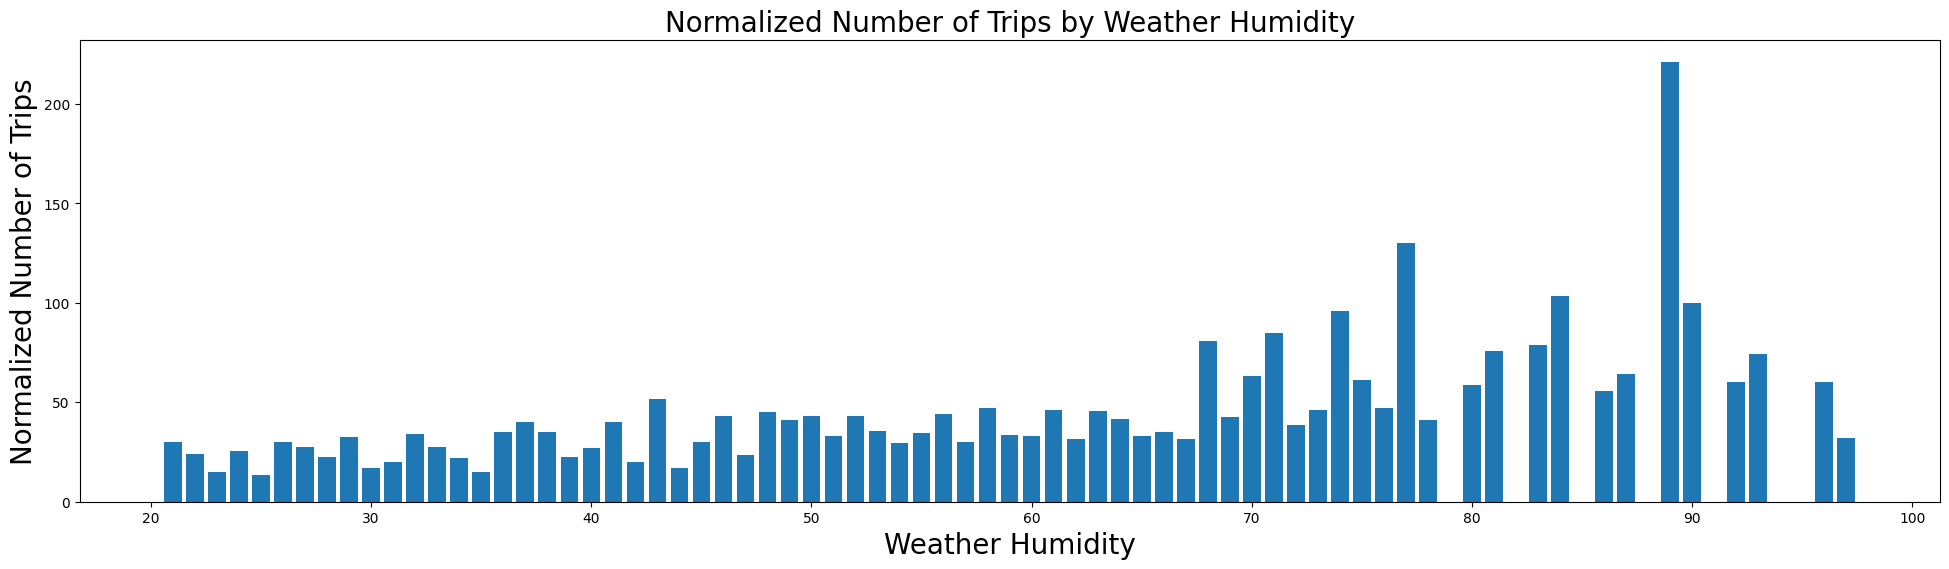

In [25]:
plt.figure(figsize=(24, 6))
plt.bar(trip_count_by_Humidity_pd['intHumidity'], trip_count_by_Humidity_pd['normalized_count'])
plt.xlabel('Weather Humidity', fontsize=20)
plt.ylabel('Normalized Number of Trips', fontsize=20)
plt.title('Normalized Number of Trips by Weather Humidity', fontsize=20)
plt.show()